# Introduction to langchain framework

### Installing Langchain

In [ ]:
#!pip install langchain

### Installing some relevant libararies in this walk-through

In [39]:
#uncomment those lines if you donot have any of the following libraries installed
#!pip install openai
#!pip install tabulate 
#!pip install matplotlib


  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/4f/f7/a5d8ff9e9cfcaa31851a711db9844e95685927b3034e30388cd4a15aa669/matplotlib-3.8.0-cp39-cp39-macosx_10_12_x86_64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/16/d9/8a15ff67fc27c65939e454512955e1b240ec75cd201d82e115b3b63ef76d/contourpy-1.1.1-cp39-cp39-macosx_10_9_x86_64.whl.metadata
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.metadata
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/49/de/e4bab99886cfb04b4b9d7feb465fcd3f58808ee2107647414d3343bf8dc6/fonttools-4.43.1-cp39-cp39-macosx_10_9_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 1.5 MB/s eta 0:00:00a 0:00:01
  Obtaining dependency informa

In [85]:

import os
import sys
# I have made mine based on python 3.9.17
print(sys.version) 

sys.path.append('../..')

from dotenv import load_dotenv, find_dotenv
 # read local .env file
_ = load_dotenv(find_dotenv())


3.9.17 (main, Jul  5 2023, 16:17:03) 
[Clang 14.0.6 ]


### Authenticate the access to OpenAI API
- you need an account on OpenAI API in order to be able use the API. 
- When you register your account, you have some free credits to start with. 
- Afterwards you have to save the api key as an environment variable and load it to python as indicated here. 
- If you have troubles or questions with any of the steps, just ask Chat-GPT ;) 

In [41]:
import openai
openai.api_key  = os.environ['OPENAI_API_KEY']

### Import relevant packages

In [43]:
from langchain.document_loaders import PyPDFLoader
from langchain.document_loaders import CSVLoader
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import DocArrayInMemorySearch
from langchain.chat_models import ChatOpenAI
from langchain.output_parsers import ResponseSchema
from langchain.output_parsers import StructuredOutputParser
from langchain.chains import LLMChain
from langchain.chains import RetrievalQA
from langchain.chains import SequentialChain
from langchain.prompts import ChatPromptTemplate
from IPython.display import display, Markdown, Latex


### Simple Example
Chat Models

In [619]:

llm = ChatOpenAI(temperature=0.2, model_name="gpt-3.5-turbo-0301")
llm4 = ChatOpenAI(temperature=0.0, model_name="gpt-4")


from langchain.schema import AIMessage, HumanMessage, SystemMessage
messages = [
    HumanMessage(content="Good Morning!")
    ]
ai_response = llm(messages)
print(ai_response)

content='Good morning! How can I assist you today?'


![LLM Chain pipeline](./resources/llmChain.png)


Create a Prompt template, where we can pass an input variable to the LLM query. 
The input variables here are:
- language 
- The text to be translated 

In [590]:
query = "Translate the following text \
into {language}:  ' {toBeTranslated}' "
prompt = ChatPromptTemplate.from_template(query)

In [591]:
prompt

ChatPromptTemplate(input_variables=['language', 'toBeTranslated'], messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['language', 'toBeTranslated'], template="Translate the following text into {language}:  ' {toBeTranslated}' "))])

Define our input to the template

In [592]:
input_dict={"language": "Swiss German", "toBeTranslated": "Let's grab a beer!"}

Create a Chain and run it using the input

In [593]:
llm_chain = LLMChain(prompt= prompt, llm=llm)
#An LLM chain expects an input dictionary
ai_response = llm_chain.run(input_dict)


In [596]:
ai_response

'"Lueget mer en Bier!"'

Another example can be seen here

In [97]:

query = "Please tell me the ingredients I need for the recipe of {dish}?"
prompt = ChatPromptTemplate.from_template(query)
simple_chain = LLMChain(llm=llm, prompt=prompt)
input_dict = {"dish": "Paella"}
ai_response = simple_chain.run(input_dict)
display(Markdown(ai_response))

Ingredients for Paella:

- 2 cups of short-grain rice
- 4 cups of chicken or vegetable broth
- 1 pound of chicken thighs, cut into small pieces
- 1 pound of chorizo sausage, sliced
- 1 pound of shrimp, peeled and deveined
- 1 onion, chopped
- 4 cloves of garlic, minced
- 1 red bell pepper, chopped
- 1 green bell pepper, chopped
- 1 cup of frozen peas
- 1 teaspoon of smoked paprika
- 1/2 teaspoon of saffron threads
- Salt and pepper to taste
- Olive oil for cooking

Optional ingredients:

- 1 can of diced tomatoes
- 1/2 cup of white wine
- 1 lemon, cut into wedges
- Fresh parsley for garnish

### Using Simple Sequential Chains
![Simple Sequential Chain](./resources/SSChain.png)


In [659]:
from langchain.chains import SimpleSequentialChain
prompt_str1 = "Tell me the name of the calendar month of the year that comes in this position: {position}"
prompt_str2 = "Translate the name of this month {month} into French" 
prompt_str3 = "Tell me in one word the name of the following month to {translated_month} in French" #in this language{language}"

prompt1 = ChatPromptTemplate.from_template(prompt_str1)
prompt2 = ChatPromptTemplate.from_template(prompt_str2)
prompt3 = ChatPromptTemplate.from_template(prompt_str3)

chain1 = LLMChain(llm=llm, prompt=prompt1)
chain2 = LLMChain(llm=llm, prompt=prompt2)
chain3 = LLMChain(llm=llm, prompt=prompt3)

overall_chain = SimpleSequentialChain(
    chains=[chain1, chain2, chain3],
    verbose=True
)

input_dict = {
    'position' : '2'
}


In [660]:
overall_chain.run(input= input_dict)



> Entering new SimpleSequentialChain chain...
February
Février
Mars.

> Finished chain.


'Mars.'

Now, what if one of the Chains has more than 1 input/output? 
### Sequential Chain 

In [604]:
prompt_str1 = "Tell me the name of the calendar month of the year that comes in this position: {position}"
prompt_str2 = "Translate the name of this month {month} into this language {language}" 
prompt_str3 = "Tell me in one word the name of the following month to {translated_month} in {language}" #in this language{language}"

prompt1 = ChatPromptTemplate.from_template(prompt_str1)
prompt2 = ChatPromptTemplate.from_template(prompt_str2)
prompt3 = ChatPromptTemplate.from_template(prompt_str3)

chain1 = LLMChain(llm=llm, prompt=prompt1, output_key="month")
chain2 = LLMChain(llm=llm, prompt=prompt2, output_key="translated_month")
chain3 = LLMChain(llm=llm, prompt=prompt3, output_key="following_month")

overall_chain = SequentialChain(
    chains=[chain1, chain2, chain3],
    input_variables=["position", "language"],
    output_variables=["month", "translated_month","following_month"],
    verbose=True
)

input_dict = {
    'position' : '5',
    'language' : 'German'
}


In [605]:
#call the simple sequential chain with the given input 
result = overall_chain(input_dict)




> Entering new SequentialChain chain...

> Finished chain.


In [606]:
result['following_month']

'Juni.'

### Example for using external content and questioning them
![Loading Documents Flow](./resources/loading1.png)

List of available loaders in Langchain is listed here https://integrations.langchain.com/


In [125]:
import pandas as pd
df = pd.read_csv('./resources/store.csv')
df.head()

,product_name;product_type;price
0,Sony;Gaming Console;3499
1,Toshiba;Computer ;239
2,IBM;Computer ;240
3,Crash ;Video Game;50
4,FiFA;Video Game;40


In [607]:
loader_csv = CSVLoader(file_path = './resources/store.csv')
docs = loader_csv.load()
embeddings = OpenAIEmbeddings()
db = DocArrayInMemorySearch.from_documents(docs, embeddings)
qa_chain = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=db.as_retriever())
qa_chain.run(query='What is the sum of all the product prices?',
filter={"source":"./resources/store.csv"})

'The sum of all the product prices is 3709.'

### Example Combining Sequential Chains with Loading Documents
![Sequential Chain Flow](./resources/test4.png)


This is how our output shall look like 

In [651]:
subscription_models  = ResponseSchema(name="subscription_models", 
                                description="Different subscription models", type="str")
termination_policy = ResponseSchema(name="termination_policy", 
                                description="Notice period for the contract", type = "str")
provider_name   = ResponseSchema(name="name", description="name of the provider", type = "str")
output_scheme   = [provider_name, subscription_models, termination_policy]
ouput_parser = StructuredOutputParser.from_response_schemas(output_scheme)
format_instructions = ouput_parser.get_format_instructions()
display(Markdown(format_instructions))

The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":

```json
{
	"name": str  // name of the provider
	"subscription_models": str  // Different subscription models
	"termination_policy": str  // Notice period for the contract
}
```

In [654]:
def extract_info_from_pdf(pdf_filename):
    pdf_loader = PyPDFLoader(pdf_filename)
    agb_pages = pdf_loader.load()
    embeddings = OpenAIEmbeddings()
    db = DocArrayInMemorySearch.from_documents(agb_pages, embedding=embeddings)

    query = "Was ist die kuendigungsfrist des Vertrags? \
      Was sind die moeglichen Mitgliedschaftsmodelle? \
      und wie heisst der Anbieter woher diese AGB stammen?"

    prompt_text = "Translate the following text from \
      German to English: {to_be_translated}"
    
    format_text = "Extract the name of the provider, \
    the subscription models and notice period from this text inscribed by ''' \
    '''{translated_text}'''. \
    {format_instructions}"

    translate_prompt = ChatPromptTemplate.from_template(prompt_text)
    format_prompt = ChatPromptTemplate.from_template(format_text)

    retrieval_chain = RetrievalQA.from_chain_type(chain_type="stuff", llm=llm4, retriever = db.as_retriever(),                                       output_key="to_be_translated")
    translate_chain = LLMChain(llm=llm, prompt=translate_prompt, output_key="translated_text", verbose=True)
    format_chain = LLMChain(llm=llm, prompt=format_prompt, verbose=True, output_key="main_output")

    fetch_translate_chain_reg = SequentialChain(chains=[retrieval_chain, translate_chain, format_chain], 
                                            input_variables=["query", "format_instructions"], 
                                            output_variables=["to_be_translated", "translated_text", "main_output"], 
                                            verbose=True)

    input_dict = {
    'query': query,  
    'format_instructions': format_instructions 
    }

    ai_response_mix = fetch_translate_chain_reg(input_dict)
    parsed_output = ouput_parser.parse(ai_response_mix['main_output'])
    return parsed_output

#### Calling the above defined methond for a number of input documents

In [661]:
gym_data = []
for i in range(1,8):
    filename = './resources/AGB{}.pdf'.format(i)
    curr_response = extract_info_from_pdf(filename)
    gym_data.append(curr_response)

print(gym_data)
dataFrame = pd.DataFrame(gym_data)
print(dataFrame)
dataFrame.to_csv('all_providers.csv', index=False)



> Entering new SequentialChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Human: Translate the following text from       German to English: Die Kündigungsfrist des Vertrags ist auf dem Vertragsdeckblatt angegeben. Nach Ende der Mindestlaufzeit kann der Vertrag von beiden Parteien jederzeit mit einer Frist von einem Monat gekündigt werden.

Die möglichen Mitgliedschaftsmodelle sind Verträge mit Mindestvertragslaufzeit und Verträge ohne feste Vertragslaufzeit, auch "Flex-Verträge" genannt. Bei Verträgen mit Mindestvertragslaufzeit hat der Vertrag zunächst die auf dem Vertragsdeckblatt angegebene Mindestvertragslaufzeit. Bei "Flex-Verträgen" gilt der Vertrag als unbefristet geschlossen und kann von beiden Vertragsparteien mit der auf dem Vertragsdeckblatt angegebenen Kündigungsfrist zum Ende einer monatlichen Trainingsperiode gekündigt werden.

Der Anbieter, von dem diese AGB stammen, ist die RSG Group GmbH.

> Finished chain.


> Entering new LLMChain chain...

#### Visualizing some entries of the output csv document as a pandas dataframe

In [662]:
df = pd.read_csv('all_providers.csv')
df.head()

,name,subscription_models,termination_policy
0,RSG Group GmbH,Contracts with a minimum contract term and con...,The notice period for termination of the contr...
1,Holmes Place,"Contracts with minimum terms of 3, 12, and 24 ...",For contracts with a minimum term of 12 or 24 ...
2,FitX,Not specified,Not specified
3,FITSEVENELEVEN,Classic 60 membership contract and the Feel Fr...,one month at the end of the initial contract term
4,terra sports,"['Economy', 'Basic', 'Flex']",The notice period for termination of the contr...


### Using Agents with Langchain

In [611]:
import pandas as pd
from langchain.agents import create_pandas_dataframe_agent
from langchain.document_loaders import DataFrameLoader
df = pd.read_csv('./resources/encrypted_demo_data.csv')
df.head()



FileNotFoundError: [Errno 2] No such file or directory: './resources/encrypted_demo_data.csv'

In [149]:
pandas_agent = create_pandas_dataframe_agent(llm4, df, verbose=False)

In [154]:
from langchain.agents import create_csv_agent
csv_agent = create_csv_agent(llm4,"./resources/encrypted_demo_data.csv", verbose=True)

In [155]:
csv_agent.run("What was the year with the most clicks?")



> Entering new AgentExecutor chain...
Thought: To find the year with the most clicks, I need to group the data by year and sum the clicks for each year. Then, I can find the year with the maximum sum of clicks.
Action: python_repl_ast
Action Input: df.groupby('Year')['clicks'].sum().idxmax()
Observation: 2023
Thought:I now know the final answer.
Final Answer: The year with the most clicks was 2023.

> Finished chain.


'The year with the most clicks was 2023.'

In [156]:

pandas_agent.run("What is the number of clicks for 2023?")

'The number of clicks for 2023 is 10995.'

In [157]:
csv_agent("What is the difference between the highest number of \
    clicks per year and the lowest number of clicks per year?")



> Entering new AgentExecutor chain...
Thought: To find the difference between the highest and lowest number of clicks per year, I first need to group the data by year and find the sum of clicks for each year. Then I can find the maximum and minimum number of clicks and calculate the difference.
Action: python_repl_ast
Action Input: df.groupby('Year')['clicks'].sum().max() - df.groupby('Year')['clicks'].sum().min()
Observation: 3245
Thought:The difference between the highest number of clicks per year and the lowest number of clicks per year is 3245.
Final Answer: 3245

> Finished chain.


{'input': 'What is the difference between the highest number of     clicks per year and the lowest number of clicks per year?',
 'output': '3245'}

In [158]:
csv_agent.run("What is the standard deviation of the impressions?")



> Entering new AgentExecutor chain...
Thought: To find the standard deviation of a column in a pandas dataframe, we can use the `std()` function. In this case, we want to find the standard deviation of the 'impression' column.
Action: python_repl_ast
Action Input: df['impression'].std()
Observation: 739.0727484081204
Thought:The standard deviation of the impressions is approximately 739.07.
Final Answer: The standard deviation of the impressions is approximately 739.07.

> Finished chain.


'The standard deviation of the impressions is approximately 739.07.'

In [159]:
import matplotlib




> Entering new AgentExecutor chain...
Thought: To find the year with the highest impression_clicks_funnel, I need to group the data by year and calculate the sum of clicks and impressions for each year. Then, I will calculate the ratio between these two sums for each year. Finally, I will find the year with the highest ratio. To plot the impression_clicks_funnel for all years, I can use the matplotlib library.
Action: python_repl_ast
Action Input: df.groupby('Year').sum()[['impression', 'clicks']]
Observation:       impression  clicks
Year                    
2020       48973    7750
2021       55219    8727
2022       44411    8205
2023       56581   10995
Thought:I have the sum of impressions and clicks for each year. Now I will calculate the ratio between these two sums for each year.
Action: python_repl_ast
Action Input: df.groupby('Year').apply(lambda x: x['clicks'].sum() / x['impression'].sum())
Observation: Year
2020    0.158250
2021    0.158043
2022    0.184752
2023    0.1943

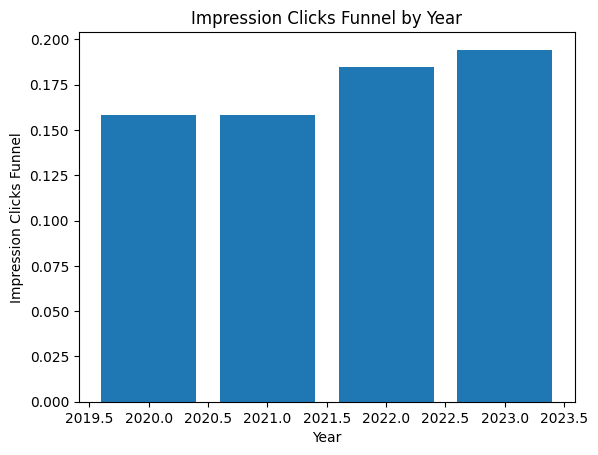


Observation: 
Thought:I have successfully plotted the impression_clicks_funnel for all years in a bar chart. The bar chart shows that the impression_clicks_funnel is highest in 2023.
Final Answer: The year with the highest impression_clicks_funnel is 2023.

> Finished chain.


{'input': 'If the impression_clicks_funnel for a given year     is the ratio between the sum of clicks and the sum of impressions in this year,         which year had the highest impression_clicks_funnel?             Please also plot the impression_clicks_funnel for all years in a bar chart',
 'output': 'The year with the highest impression_clicks_funnel is 2023.'}

In [160]:
csv_agent("If the impression_clicks_funnel for a given year \
    is the ratio between the sum of clicks and the sum of impressions in this year, \
        which year had the highest impression_clicks_funnel? \
            Please also plot the impression_clicks_funnel for all years in a bar chart")